# Задание 1

Реализовал byte-level BPE. Вдохновлялся видеороликом Let's build the GPT Tokenizer от Andrej Karpathy и его гайдом https://github.com/karpathy/minbpe/blob/master/exercise.md

In [1]:
# посчитать частоту пар (pair, count)
def get_stats(ids, counts=None):
    counts = {} if counts is None else counts
    for pair in zip(ids, ids[1:]):
        counts[pair] = counts.get(pair, 0) + 1
    return counts

In [2]:
# в токенах ids заменить пары pair на токен idx
def merge(ids, pair, idx):
    new_ids = []
    i = 0
    while i < len(ids):
        if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
            new_ids.append(idx)
            i += 2
        else:
            new_ids.append(ids[i])
            i += 1
    return new_ids

In [3]:
text = "Ｕｎｉｃｏｄｅ! 🅤🅝🅘🅒🅞🅓🅔‽ 🇺‌🇳‌🇮‌🇨‌🇴‌🇩‌🇪! 😄 The very name strikes fear and awe into the hearts of programmers worldwide. We all know we ought to “support Unicode” in our software (whatever that means—like using wchar_t for all the strings, right?). But Unicode can be abstruse, and diving into the thousand-page Unicode Standard plus its dozens of supplementary annexes, reports, and notes can be more than a little intimidating. I don’t blame programmers for still finding the whole thing mysterious, even 30 years after Unicode’s inception."
initial_tokens = text.encode("utf-8")
stats = get_stats(initial_tokens)
top_pair = max(stats, key=stats.get)
print(top_pair)

(101, 32)


In [4]:
stats = get_stats(text)
top_pair = max(stats, key=stats.get)
print(top_pair)

('e', ' ')


In [5]:
list("hello".encode("utf-8"))

[104, 101, 108, 108, 111]

Для начала реализовал обычный токенайзер без использования претокенизации и поддержки спец символов

In [6]:
class BasicTokenizer:
    def __init__(self):
        # (int, int) -> int
        self.merges = {}
        # int -> byte
        self.vocab = {}
    
    # обучить токенизатор:
    # 1) получить список ids, которые мы смерджим и их новые idx
    # 2) для новых смердженных ids нужно получить список текстовых соответствий
    # - просто конкатенация соответствующих байтов в случае byte-level
    def train(self, text, vocab_size, verbose=False):
        assert vocab_size >= 256
        merges = {}
        vocab = {idx: bytes([idx]) for idx in range(256)}
        
        tokens = list(map(int, text.encode("utf-8")))
        merges_count = vocab_size - len(vocab)
        i = 0
        while i < merges_count:
            stats = get_stats(tokens)
            if not stats:
                break
            top_pair = max(stats, key=stats.get)
            new_idx = 256 + i
            tokens = merge(tokens, top_pair, new_idx)
            merges[top_pair] = new_idx
            vocab[new_idx] = vocab[top_pair[0]] + vocab[top_pair[1]]
            i += 1
        self.vocab = vocab
        self.merges = merges

    # из текста в токены
    def encode(self, text):
        tokens = list(map(int, text.encode("utf-8")))
        # в целом можно было идти по всему merges и просто искать соответствующие пары в нашем тексте, 
        # но это было бы более ресурсозатратно O(mn), m - размер merges, n - кол-во пар
        # в merges ищем самый первый мердж среди тех пар, что есть в нашем текущем тексте
        while len(tokens) > 1:
            pairs = set(zip(tokens, tokens[1:]))
            # stats = get_stats(tokens) - как у karpathy неэффективно
            # O(kn), k - кол-во попавшихся мерджей, n - кол-во пар в pairs
            pair = min(pairs, key=lambda p: self.merges.get(p, float("inf")))
            if pair not in self.merges: # случай float("inf") - мерджи закончились
                break
            idx = self.merges[pair]
            tokens = merge(tokens, pair, idx)
            
        return tokens

    # из токенов в текст
    def decode(self, ids):
        _bytes = b"".join(self.vocab[idx] for idx in ids)
        return _bytes.decode("utf-8", errors="replace")

Конкатенация байтов не всегда даст валидный результат для кодировки utf-8

In [7]:
tokenizer = BasicTokenizer()

In [8]:
tokenizer.train(text, 270)

In [9]:
tokenizer.encode("hello")

[104, 101, 108, 108, 111]

In [10]:
tokenizer.decode(tokenizer.encode("hello"))

'hello'

Использовал регулярку для претокенизации от GPT-4

In [11]:
GPT4_SPLIT_PATTERN = r"""'(?i:[sdmt]|ll|ve|re)|[^\r\n\p{L}\p{N}]?+\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]++[\r\n]*|\s*[\r\n]|\s+(?!\S)|\s+"""

Теперь реализую токенайзер с претокенизацией и поддержкой спец символов

In [12]:
import regex as re

In [13]:
class RegexTokenizer:
    def __init__(self, pattern=None):
        # (int, int) -> int
        self.merges = {}
        # int -> byte(s)
        self.vocab = {}
        self.pattern = GPT4_SPLIT_PATTERN if pattern is None else pattern
        self.compiled_pattern = re.compile(self.pattern)
        # str -> int
        self.special_tokens = {}
        # int -> str
        self.inverse_special_tokens = {} 
        
    
    # обучить токенизатор:
    # 1) получить список ids, которые мы смерджим и их новые idx
    # 2) для новых смердженных ids нужно получить список текстовых соответствий
    # - просто конкатенация соответствующих байтов в случае byte-level
    def train(self, text, vocab_size, verbose=False):
        assert vocab_size >= 256

        splitted_text = re.findall(self.compiled_pattern, text)
        
        merges = {}
        vocab = {idx: bytes([idx]) for idx in range(256)}
        
        tokens_arr = [list(map(int, split.encode("utf-8"))) for split in splitted_text]
        merges_count = vocab_size - len(vocab)
        i = 0
        while i < merges_count:
            stats = {}
            for tokens in tokens_arr:
                get_stats(tokens, stats)
            top_pair = max(stats, key=stats.get)
            new_idx = 256 + i
            tokens_arr = [merge(tokens, top_pair, new_idx) for tokens in tokens_arr]
            merges[top_pair] = new_idx
            vocab[new_idx] = vocab[top_pair[0]] + vocab[top_pair[1]]
            i += 1
        self.vocab = vocab
        self.merges = merges

    def register_special_tokens(self, special_tokens):
        self.special_tokens = special_tokens
        self.inverse_special_tokens = {v: k for k,v in special_tokens.items()}

    # из текста в токены
    def _encode_split(self, split):
        tokens = list(map(int, split.encode("utf-8")))
        # в целом можно было идти по всему merges и просто искать соответствующие пары в нашем тексте, 
        # но это было бы более ресурсозатратно O(mn), m - размер merges, n - кол-во пар
        # в merges ищем самый первый мердж среди тех пар, что есть в нашем текущем тексте
        while len(tokens) > 1:
            pairs = set(zip(tokens, tokens[1:]))
            # stats = get_stats(tokens) - как у karpathy неэффективно
            # O(kn), k - кол-во попавшихся мерджей, n - кол-во пар в pairs
            pair = min(pairs, key=lambda p: self.merges.get(p, float("inf")))
            if pair not in self.merges: # случай float("inf") - мерджи закончились
                break
            idx = self.merges[pair]
            tokens = merge(tokens, pair, idx)
        return tokens
        
    def encode_ordinary(self, text):
        splitted_text = re.findall(self.compiled_pattern, text)
        tokens = []
        for split in splitted_text:
            tokens.extend(self._encode_split(split))
        return tokens

    
    def encode(self, text, allowed_special="none_raise"):
        special = None
        if allowed_special == "all":
            special = self.special_tokens
        elif allowed_special == "none":
            special = {}
        elif allowed_special == "none_raise":
            special = {}
            assert all(special_token not in text for special_token in self.special_tokens)
        elif isinstance(allowed_special, set):
            special = {k: v for k, v in self.special_tokens.items() if k in allowed_special}
        else:
            raise ValueError(f"allowed_special={allowed_special} not understood")
            
        if not special:
            return self.encode_ordinary(text)
        
        # иначе сплитим текст по спец токенам
        special_pattern = "(" + "|".join(re.escape(k) for k in special) + ")"
        special_splits = re.split(special_pattern, text)

        tokens = []
        for split in special_splits:
            if split in special:
                tokens.append(special[split])
            else:
                tokens.extend(self.encode_ordinary(split))
        return tokens
                
    # из токенов в текст
    def decode(self, ids):
        bytes_arr = []
        for idx in ids:
            if idx in self.inverse_special_tokens:
                bytes_arr.append(self.inverse_special_tokens[idx].encode("utf-8"))
            elif idx in self.vocab:
                bytes_arr.append(self.vocab[idx])
            else:
                raise ValueError(f"invalid token id: {idx}")
        _bytes = b"".join(bytes_arr)
        return _bytes.decode("utf-8", errors="replace")

Обучаю на англоязычном тексте

In [40]:
with open("/kaggle/input/shakespear/tiny_shakespear.txt", "r") as f:
    text = f.read()

In [15]:
tokenizer = RegexTokenizer()

Обучаю маленький словарь, 1000 токенов, т.к. из-за того, что токенайзер полностью написан на нативном Python, то он работает долго

In [16]:
tokenizer.train(text, 1000)

Определяю функцию для подсчета соответствующих метрик из задания с выводом консоль + возвратом значений, чтобы потом можно было построить графики для разных текстов

In [17]:
def calculate_and_print_metrics(text):
    tokens = tokenizer.encode(text)
    
    tokens_count = len(tokens)
    words_count = len(text.split())
    bytes_count = len(text.encode('utf-8'))
    
    compression = tokens_count / bytes_count
    
    avg_tokens_per_word = tokens_count / words_count
    
    import collections
    
    words_freq = collections.Counter(text.split())
    sorted_words_by_freq = sorted(words_freq.keys(), key = lambda w: words_freq[w], reverse=True)
    top10_percent_count = int(len(sorted_words_by_freq) * 0.1)
    top10_percent_words = sorted_words_by_freq[:top10_percent_count]
    
    tokens_count_top10 = 0
    for w in top10_percent_words:
        tokens_count_top10 += len(tokenizer.encode(w))
    
    avg_tokens_per_top10_percent_word = tokens_count_top10 / len(top10_percent_words)

    print(f"Коэф сжатия: {compression}")
    print(f"Среднее кол-во токенов на слово: {avg_tokens_per_word}")
    print(f"Среднее кол-во токенов на топ 10% слов по частоте: {avg_tokens_per_top10_percent_word}")

    return {
        "compression_ratio": compression,
        "avg_tokens_per_word": avg_tokens_per_word,
        "avg_tokens_top_10": avg_tokens_per_top10_percent_word
    }

In [18]:
import matplotlib.pyplot as plt

In [19]:
def plot_vocab_vs_compression(tokenizer, text, domain_name, steps=10):
    original_merges = tokenizer.merges.copy()
    original_vocab = tokenizer.vocab.copy()
    
    full_vocab_size = len(original_vocab)
    total_merges = len(original_merges)

    vocab_sizes = []
    compression_ratios = []
    
    step_size = max(1, total_merges // steps)
    merges_items = list(original_merges.items())
    
    # проверяю для размера 256 (0 мерджей)
    tokenizer.merges = {} 
    print(f"{domain_name}: 256")
    
    metrics = calculate_and_print_metrics(text)
    vocab_sizes.append(256)
    compression_ratios.append(metrics['compression_ratio'])

    # далее проверяю промежуточные значения
    for i in range(step_size, total_merges + 1, step_size):
        current_merges_slice = dict(merges_items[:i])
        current_vocab_size = 256 + i
        
        tokenizer.merges = current_merges_slice
        
        print(f"{domain_name}: {current_vocab_size}")
        
        metrics = calculate_and_print_metrics(text)
        
        vocab_sizes.append(current_vocab_size)
        compression_ratios.append(metrics["compression_ratio"])
    
    # возвращаем оригинальные значения
    tokenizer.merges = original_merges
    tokenizer.vocab = original_vocab
    
    plt.figure(figsize=(10, 6))
    plt.plot(vocab_sizes, compression_ratios, marker='o')
    plt.title(f"Vocabulary Size vs Compression Ratio ({domain_name})")
    plt.xlabel("Vocabulary Size")
    plt.ylabel("Compression Ratio (bytes/token)")
    plt.grid(True)
    plt.show()

In [20]:
domains_data = {
    "English" : "Human settlement on the territory of modern Russia dates back to the Lower Paleolithic. The East Slavs emerged as a formidable group in Europe between the 3rd and 8th centuries AD. The first East Slavic state, Kievan Rus', arose in the 9th century, and in 988 adopted Orthodox Christianity from the Byzantine Empire. The latter ultimately disintegrated, and the Grand Duchy of Moscow led the unification of Russian lands in the late 13th century, leading to the proclamation of the Tsardom of Russia in 1547. By the early 18th century, Russia had expanded vastly through conquest, annexation, and the efforts of Russian explorers, developing into the Russian Empire, which remains the third-largest empire in history. The Russian Revolution of 1917 led to the monarchic system being abolished and replaced by the first constitutionally socialist state in the world. Following the Russian Civil War, Soviet Russia established the Soviet Union as its largest and principal constituent. The Soviet Union underwent rapid industrialisation in the 1930s, amidst the death of millions under the dictatorship of Joseph Stalin, and later played a decisive role for the Allies in World War II by leading large-scale efforts on the Eastern Front—emerging as a global superpower. During the Cold War, it competed with the United States for ideological dominance and international influence. The 20th-century Soviet era saw some of the most significant technological achievements in human history, including the first human-made satellite and the first human expedition into outer space.",
    "Russian" : "Россия — многонациональное государство с широким этнокультурным многообразием. Согласно результатам переписей населения России 2010 года в стране живут представители свыше 190 национальностей, среди которых русские составляют свыше 80 %, а русским языком владеют свыше 99,4 % россиян. Большая часть населения (около 75 %) в религиозном отношении относит себя к православию, что делает Россию страной с самым многочисленным православным населением в мире",
    "Russian scientific" : "Мы называем два диффеоморфных многообразия изометричными с точностью до если не более чем на отличаются их римановы метрики, а также их производные порядков не более В частности, кривизны на этих окрестностях сравнимы со скалярной кривизной R(x, t). Размер окрестностей, соответствующих случаям i) и ii), сравним с(x, t). Кроме того, пространственные и временные колебания оцениваются универсальными константами.",
    "C++" : "#include <iostream> #include <thread> std::queue<std::unique_ptr<Packet>> firstQueue; void FirstHandler::processHandler(std::unique_ptr<Packet> packet, pcap_dumper_t *dumper, size_t &packetCount) { uint16_t destPort; // Проверяем, какой транспортный протокол используется if (packet->ipHeader->ip_p == IPPROTO_TCP) { const struct tcphdr *tcpHeader = reinterpret_cast<const struct tcphdr *>(packet->transportHeader); destPort = ntohs(tcpHeader->th_dport); } else if (packet->ipHeader->ip_p == IPPROTO_UDP) { const struct udphdr *udpHeader = reinterpret_cast<const struct udphdr *>(packet->transportHeader); destPort = ntohs(udpHeader->uh_dport); } if (destPort == 7070) { std::cout  << packetCount << std::endl; } else { pcap_dump((u_char *)dumper, &packet->header, packet->data.data()); packetCount++; } } void FirstHandler::handler() { size_t packetCount = 0; const char pcap_t *handle = pcap_open_dead(DLT_EN10MB, 65535); pcap_dumper_t *dumper = pcap_dump_open(handle, name); while (true) { // Ждем пока не появятся элементы в очереди if (firstQueue.empty()) { std::this_thread::sleep_for(std::chrono::milliseconds(100)); continue; } std::unique_ptr<Packet> packet = std::move(firstQueue.front()); firstQueue.pop(); if (packet == nullptr) break; processHandler(std::move(packet), dumper, packetCount); } pcap_dump_close(dumper); pcap_close(handle);",
    "Python" : """def f_test(df1, df2):
    var1 = np.var(df1, ddof=1)
    var2 = np.var(df2, ddof=1)
    if var1 > var2:
        f_statistic = var1/var2
        dof1 = len(df1) - 1
        dof2 = len(df2) - 1
    else:
        f_statistic = var2/var1
        dof1 = len(df2) - 1
        dof2 = len(df1) - 1
    p_value = stats.f.sf(f_statistic, dof1, dof2)
    return p_value"""
}

Коэф сжатия: 0.48096446700507617
Среднее кол-во токенов на слово: 3.1065573770491803
Среднее кол-во токенов на топ 10% слов по частоте: 2.2
Коэф сжатия: 1.0
Среднее кол-во токенов на слово: 13.475409836065573
Среднее кол-во токенов на топ 10% слов по частоте: 8.8
Коэф сжатия: 0.9959731543624161
Среднее кол-во токенов на слово: 13.25
Среднее кол-во токенов на топ 10% слов по частоте: 5.0
Коэф сжатия: 0.706993006993007
Среднее кол-во токенов на слово: 7.717557251908397
Среднее кол-во токенов на топ 10% слов по частоте: 2.25
Коэф сжатия: 0.770949720670391
Среднее кол-во токенов на слово: 5.63265306122449
Среднее кол-во токенов на топ 10% слов по частоте: 1.0
Russian: 1.00 bytes/token
Russian scientific: 1.00 bytes/token
Python: 0.77 bytes/token
C++: 0.71 bytes/token
English: 0.48 bytes/token


English: 256
Коэф сжатия: 1.0
Среднее кол-во токенов на слово: 6.459016393442623
Среднее кол-во токенов на топ 10% слов по частоте: 3.7333333333333334
English: 330
Коэф сжатия: 0.6789340101522843
Среднее кол-во токенов на слово: 4.385245901639344
Среднее кол-во токенов на топ 10% слов по частоте: 3.0
English: 404
Коэф сжатия: 0.6110406091370558
Среднее кол-во токенов на слово: 3.94672131147541
Среднее кол-во токенов на топ 10% слов по частоте: 2.533333333333333
English: 478
Коэф сжатия: 0.5653553299492385
Среднее кол-во токенов на слово: 3.651639344262295
Среднее кол-во токенов на топ 10% слов по частоте: 2.466666666666667
English: 552
Коэф сжатия: 0.5406091370558376
Среднее кол-во токенов на слово: 3.4918032786885247
Среднее кол-во токенов на топ 10% слов по частоте: 2.466666666666667
English: 626
Коэф сжатия: 0.5228426395939086
Среднее кол-во токенов на слово: 3.377049180327869
Среднее кол-во токенов на топ 10% слов по частоте: 2.4
English: 700
Коэф сжатия: 0.5133248730964467
Среднее

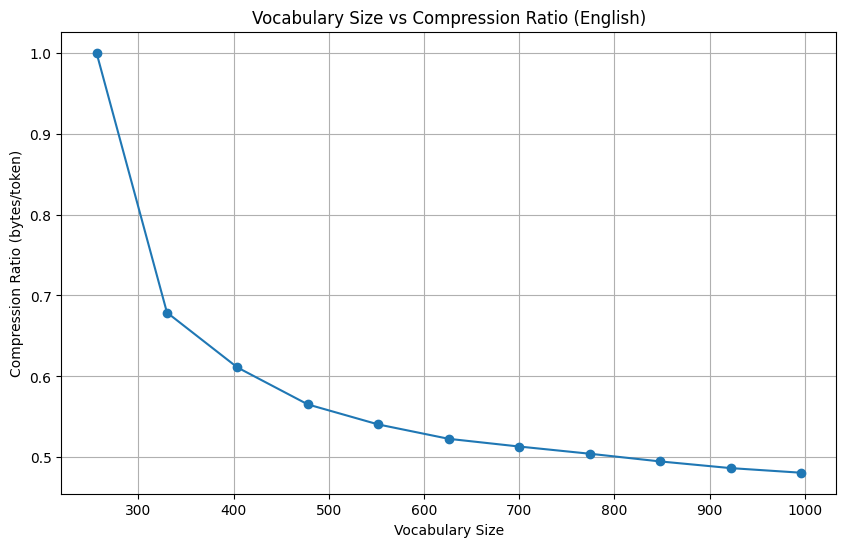

Russian: 256
Коэф сжатия: 1.0
Среднее кол-во токенов на слово: 13.475409836065573
Среднее кол-во токенов на топ 10% слов по частоте: 8.8
Russian: 330
Коэф сжатия: 1.0
Среднее кол-во токенов на слово: 13.475409836065573
Среднее кол-во токенов на топ 10% слов по частоте: 8.8
Russian: 404
Коэф сжатия: 1.0
Среднее кол-во токенов на слово: 13.475409836065573
Среднее кол-во токенов на топ 10% слов по частоте: 8.8
Russian: 478
Коэф сжатия: 1.0
Среднее кол-во токенов на слово: 13.475409836065573
Среднее кол-во токенов на топ 10% слов по частоте: 8.8
Russian: 552
Коэф сжатия: 1.0
Среднее кол-во токенов на слово: 13.475409836065573
Среднее кол-во токенов на топ 10% слов по частоте: 8.8
Russian: 626
Коэф сжатия: 1.0
Среднее кол-во токенов на слово: 13.475409836065573
Среднее кол-во токенов на топ 10% слов по частоте: 8.8
Russian: 700
Коэф сжатия: 1.0
Среднее кол-во токенов на слово: 13.475409836065573
Среднее кол-во токенов на топ 10% слов по частоте: 8.8
Russian: 774
Коэф сжатия: 1.0
Среднее кол

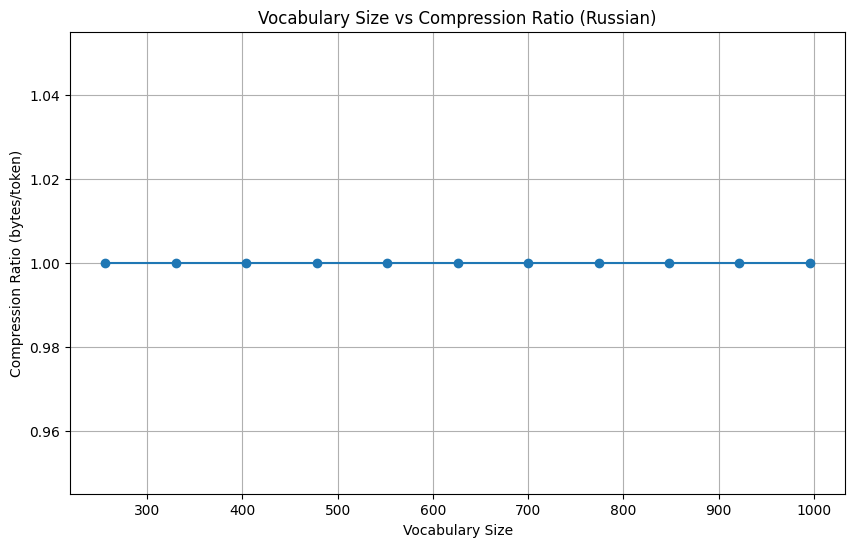

Russian scientific: 256
Коэф сжатия: 1.0
Среднее кол-во токенов на слово: 13.303571428571429
Среднее кол-во токенов на топ 10% слов по частоте: 5.0
Russian scientific: 330
Коэф сжатия: 0.9973154362416108
Среднее кол-во токенов на слово: 13.267857142857142
Среднее кол-во токенов на топ 10% слов по частоте: 5.0
Russian scientific: 404
Коэф сжатия: 0.9973154362416108
Среднее кол-во токенов на слово: 13.267857142857142
Среднее кол-во токенов на топ 10% слов по частоте: 5.0
Russian scientific: 478
Коэф сжатия: 0.9959731543624161
Среднее кол-во токенов на слово: 13.25
Среднее кол-во токенов на топ 10% слов по частоте: 5.0
Russian scientific: 552
Коэф сжатия: 0.9959731543624161
Среднее кол-во токенов на слово: 13.25
Среднее кол-во токенов на топ 10% слов по частоте: 5.0
Russian scientific: 626
Коэф сжатия: 0.9959731543624161
Среднее кол-во токенов на слово: 13.25
Среднее кол-во токенов на топ 10% слов по частоте: 5.0
Russian scientific: 700
Коэф сжатия: 0.9959731543624161
Среднее кол-во токен

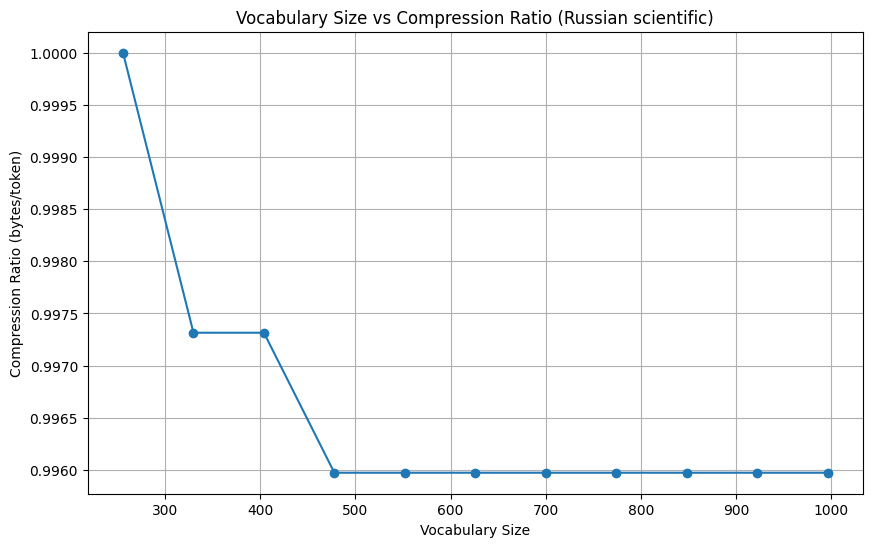

C++: 256
Коэф сжатия: 1.0
Среднее кол-во токенов на слово: 10.916030534351146
Среднее кол-во токенов на топ 10% слов по частоте: 3.25
C++: 330
Коэф сжатия: 0.862937062937063
Среднее кол-во токенов на слово: 9.419847328244275
Среднее кол-во токенов на топ 10% слов по частоте: 2.75
C++: 404
Коэф сжатия: 0.8132867132867133
Среднее кол-во токенов на слово: 8.877862595419847
Среднее кол-во токенов на топ 10% слов по частоте: 2.625
C++: 478
Коэф сжатия: 0.793006993006993
Среднее кол-во токенов на слово: 8.65648854961832
Среднее кол-во токенов на топ 10% слов по частоте: 2.375
C++: 552
Коэф сжатия: 0.7776223776223776
Среднее кол-во токенов на слово: 8.488549618320612
Среднее кол-во токенов на топ 10% слов по частоте: 2.375
C++: 626
Коэф сжатия: 0.7468531468531469
Среднее кол-во токенов на слово: 8.15267175572519
Среднее кол-во токенов на топ 10% слов по частоте: 2.375
C++: 700
Коэф сжатия: 0.7251748251748251
Среднее кол-во токенов на слово: 7.916030534351145
Среднее кол-во токенов на топ 10% 

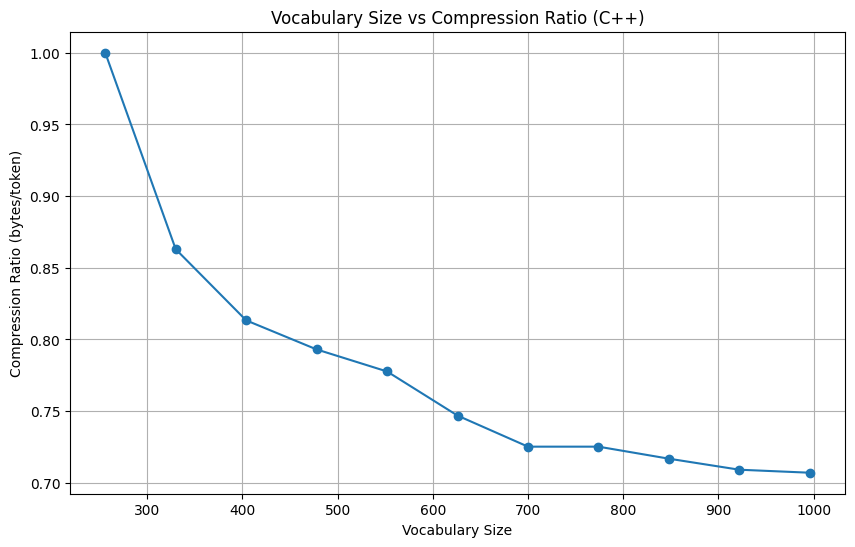

Python: 256
Коэф сжатия: 1.0
Среднее кол-во токенов на слово: 7.3061224489795915
Среднее кол-во токенов на топ 10% слов по частоте: 1.0
Python: 330
Коэф сжатия: 0.8575418994413407
Среднее кол-во токенов на слово: 6.26530612244898
Среднее кол-во токенов на топ 10% слов по частоте: 1.0
Python: 404
Коэф сжатия: 0.8184357541899442
Среднее кол-во токенов на слово: 5.979591836734694
Среднее кол-во токенов на топ 10% слов по частоте: 1.0
Python: 478
Коэф сжатия: 0.7932960893854749
Среднее кол-во токенов на слово: 5.795918367346939
Среднее кол-во токенов на топ 10% слов по частоте: 1.0
Python: 552
Коэф сжатия: 0.7905027932960894
Среднее кол-во токенов на слово: 5.775510204081633
Среднее кол-во токенов на топ 10% слов по частоте: 1.0
Python: 626
Коэф сжатия: 0.776536312849162
Среднее кол-во токенов на слово: 5.673469387755102
Среднее кол-во токенов на топ 10% слов по частоте: 1.0
Python: 700
Коэф сжатия: 0.7737430167597765
Среднее кол-во токенов на слово: 5.653061224489796
Среднее кол-во токено

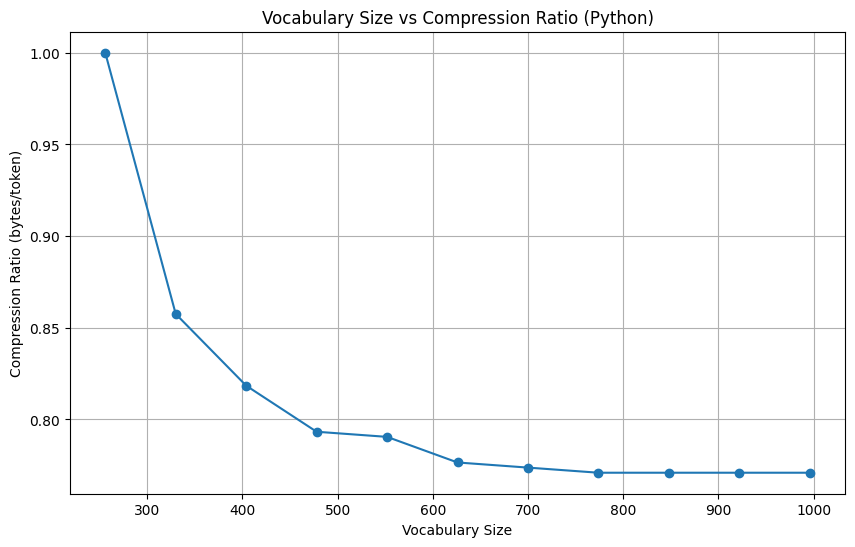

In [21]:
for domain, dtext in domains_data.items():
    results[domain] = plot_vocab_vs_compression(tokenizer, dtext, domain)

Так как токенайзер был обучен на английском языке, а в utf-8 один символ из латиницы => один байт, в то время как для русских букв это 2 байта, то токенайзер не выучил никаких мерджей и просто переводит кириллицу в байты по utf-8. Также видно, что для многих доменов, начиная с какого-то момента выходим на плато

In [22]:
import glob

In [115]:
def analyze_unused_tokens(tokenizer, path_pattern='/kaggle/input/pushkin-texts/*.txt'):
    file_list = glob.glob(path_pattern)
    full_text = ""
        
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8') as f:
            full_text += f.read() + "\n"

    ids = tokenizer.encode(full_text)
    
    used_tokens = set(ids)
    all_vocab_tokens = set(tokenizer.vocab.keys())
    unused_tokens = all_vocab_tokens - used_tokens
    
    print(f"Всего токенов: {len(all_vocab_tokens)}")
    print(f"Использовано: {len(used_tokens)} ({len(used_tokens)/len(all_vocab_tokens)*100}%)")
    print(f"Не использовано: {len(unused_tokens)}")
    
    print("Топ 10 использованных токенов:")
    for tid in sorted(used_tokens)[:10]:
        print(f"  ID={tid}: '{tokenizer.decode([tid])}'")
    
    print("Топ 10 неиспользованных токенов:")
    for tid in sorted(unused_tokens)[:10]:
        print(f"  ID={tid}: '{tokenizer.decode([tid])}'")

In [114]:
analyze_unused_tokens(tokenizer)

Всего токенов: 1000
Использовано: 470 (47.0%)
Не использовано: 530
Топ 10 использованных токенов:
  ID=10: '
'
  ID=32: ' '
  ID=33: '!'
  ID=39: '''
  ID=40: '('
  ID=41: ')'
  ID=42: '*'
  ID=44: ','
  ID=45: '-'
  ID=46: '.'
  ID=47: '/'
  ID=48: '0'
  ID=49: '1'
  ID=50: '2'
  ID=51: '3'
  ID=52: '4'
  ID=53: '5'
  ID=54: '6'
  ID=55: '7'
  ID=56: '8'
  ID=57: '9'
  ID=58: ':'
  ID=59: ';'
  ID=60: '<'
  ID=62: '>'
  ID=63: '?'
  ID=65: 'A'
  ID=66: 'B'
  ID=67: 'C'
  ID=68: 'D'
  ID=69: 'E'
  ID=70: 'F'
  ID=71: 'G'
  ID=72: 'H'
  ID=73: 'I'
  ID=74: 'J'
  ID=75: 'K'
  ID=76: 'L'
  ID=77: 'M'
  ID=78: 'N'
  ID=79: 'O'
  ID=80: 'P'
  ID=81: 'Q'
  ID=82: 'R'
  ID=83: 'S'
  ID=84: 'T'
  ID=85: 'U'
  ID=86: 'V'
  ID=87: 'W'
  ID=88: 'X'
Топ 10 неиспользованных токенов:
  ID=0: ' '
  ID=1: ''
  ID=2: ''
  ID=3: ''
  ID=4: ''
  ID=5: ''
  ID=6: ''
  ID=7: ''
  ID=8: '
  ID=9: '	'


Возможно некоторые байтовые конкатенации из латинских букв совпали с байтовыми представлениями русских букв по utf-8, либо есть файл на английском, помимо базовых ascii

# Задание 2

In [79]:
import torch
import torch.nn as nn
from torch.nn import functional as F

BATCH_SIZE = 32
BLOCK_SIZE = 128  # длина контекста / размерность позиционных эмбеддингов
MAX_ITERS = 3500
LEARNING_RATE = 3e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBED_DIM = 128 # размерность эмбеддингов токенов
N_HEAD = 4
N_LAYER = 2 # число слоев трансформера подряд
DROPOUT = 0.1

print(f"{DEVICE}")

cuda


Комментарии писал в основном для себя, читать не обязательно

In [80]:
def get_batch(data, block_size, batch_size):
    # беру batch_size случайных индексов
    ix = torch.randint(len(data) - block_size, (batch_size,))
    # беру batch_size векторов размером block_size и складываю в stack => получаю матрицу
    # по сути batch_size случайных последовательностей токенов размера block_size
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(DEVICE), y.to(DEVICE)
    return x, y

In [94]:
encoded_data = tokenizer.encode(text, allowed_special="none")
train_data = torch.tensor(encoded_data, dtype=torch.long)

In [95]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_head, n_layer):
        super().__init__()
        # матрица эмбеддингов токенов размера vocab_size => vocab_size * embed_dim
        self.token_embedding_table = nn.Embedding(vocab_size, embed_dim)
        # позиционные эмбеддинги размера BLOCK_SIZE => BLOCK_SIZE * embed_dim
        self.position_embedding_table = nn.Embedding(BLOCK_SIZE, embed_dim)

        # каждая голова получает часть embed_dim / n_head
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=n_head, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layer)
        
        # линейный слой vocab_size * embed_dim => vocab_size
        self.lm_head = nn.Linear(embed_dim, vocab_size)

    def forward(self, idx, targets=None):
        batch_size, block_size = idx.shape
        # получаю эмбеддинги токенов для каждого элемента в последовательности из каждого батча
        tok_emb = self.token_embedding_table(idx) # (batch_size, block_size, embed_dim)
        # получаю эмбеддинги позиций для каждого элемента в последовательности
        pos_emb = self.position_embedding_table(torch.arange(block_size, device=DEVICE)) # (block_size, embed_dim)
        
        # к каждой последовательности эмбеддингов токенов в батче прибавляю последовательность эмбеддингов позиций
        x = tok_emb + pos_emb
        
        # маска для законного подсчета attention scores
        mask = nn.Transformer.generate_square_subsequent_mask(block_size).to(DEVICE)
        # на вход подаю батч последвательностей эмбеддингов с маской
        x = self.transformer(x, mask=mask, is_causal=True)
        # на выходе из трансформера получаем обновленные эмбеддинги в последовательностях
        # с учетом взвешивания по увиденным эмбеддингам по softmax по attention scores
        
        # применяем линейный слой к каждому эмбеддингу
        logits = self.lm_head(x) # (batch_size, block_size, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            # берем только последние BLOCK_SIZE токена
            idx_cond = idx[:, -BLOCK_SIZE:]
            
            logits, loss = self(idx_cond)
            
            # т.к. все слова в BLOCK_SIZE известны, нужно посмотреть вероятность для токена после последнего
            logits = logits[:, -1, :] # batch_size * vocab_size
            probs = F.softmax(logits, dim=-1)
            
            # по вероятностям берем токен
            idx_next = torch.multinomial(probs, num_samples=1) # batch_size * 1
            
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In [96]:
model = Transformer(vocab_size, EMBED_DIM, N_HEAD, N_LAYER).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [97]:
for step in range(MAX_ITERS):
    xb, yb = get_batch(train_data, BLOCK_SIZE, BATCH_SIZE)
    
    # forward
    logits, loss = model(xb, yb)
    
    # backward
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step}: loss {loss.item():}")

print(f"Финальный loss: {loss.item():}")

Step 0: loss 7.062894821166992
Step 100: loss 5.904982089996338
Step 200: loss 5.238537311553955
Step 300: loss 4.848044395446777
Step 400: loss 4.667192459106445
Step 500: loss 4.468963623046875
Step 600: loss 4.404430389404297
Step 700: loss 4.2854838371276855
Step 800: loss 4.253139495849609
Step 900: loss 4.266637802124023
Step 1000: loss 4.19154167175293
Step 1100: loss 4.1009135246276855
Step 1200: loss 4.101035118103027
Step 1300: loss 4.1534013748168945
Step 1400: loss 3.981193780899048
Step 1500: loss 3.9680285453796387
Step 1600: loss 4.05304479598999
Step 1700: loss 3.9903409481048584
Step 1800: loss 3.9919238090515137
Step 1900: loss 3.976536273956299
Step 2000: loss 3.9408812522888184
Step 2100: loss 3.9833362102508545
Step 2200: loss 3.875319480895996
Step 2300: loss 3.831719398498535
Step 2400: loss 3.8152215480804443
Step 2500: loss 3.796586751937866
Step 2600: loss 3.8839311599731445
Step 2700: loss 3.8494513034820557
Step 2800: loss 3.863938331604004
Step 2900: loss 3

In [93]:
start_context = "how"
context_ids = tokenizer.encode(start_context)
context_tensor = torch.tensor(context_ids, dtype=torch.long, device=DEVICE).unsqueeze(0)

generated_ids = model.generate(context_tensor, max_new_tokens=100)

generated_text = tokenizer.decode(generated_ids[0].tolist())

print(generated_text)

how gentlege through, or heavy must be there, being swour lim by the glor, as your
good in thy ne'er ear. Over fereded rememle, is very dear
to the succot compics say would, which which the bold bod fired,
I prayers thou I duke the journment; and the sk be known past sea,
Why


Из-за маленького словаря (всего 1000 токенов), маленького датасета (40к строк) для обучения и гиперпараметров модель допускает много орфографических ошибок при составлении слов, но при этом можно уловить что-то схожее по стилистике с пьесами Шекспира, на которых и обучались токенайзер и модель, хоть и без особого смысла

# Задание 3

In [116]:
from transformers import GPT2LMHeadModel, GPT2Config
from torch.utils.data import TensorDataset, DataLoader

2025-12-26 00:49:32.026003: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766710172.271966      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766710172.351564      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766710172.982291      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766710172.982333      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766710172.982336      55 computation_placer.cc:177] computation placer alr

In [119]:
with open("/kaggle/input/war-and-peace-small/war_and_peace.txt", "r", encoding='utf-8') as f:
    text = f.read()

Обучаю свой токенизатор на русском тексте, а именно на обрывке из романа "Война и мир" примерно на 130 тыс. слов

In [120]:
NEW_VOCAB_SIZE = 5000 
tokenizer = RegexTokenizer()
tokenizer.train(text, NEW_VOCAB_SIZE, verbose=True)

EOT_TOKEN_ID = NEW_VOCAB_SIZE
tokenizer.register_special_tokens({"<|endoftext|>": EOT_TOKEN_ID})
NEW_VOCAB_SIZE += 1

In [129]:
model = GPT2LMHeadModel.from_pretrained('gpt2') 
old_vocab_size = model.config.vocab_size
print(f"Размер base словаря GPT2: {old_vocab_size}"), 
print(f"Размер моего словаря: {NEW_VOCAB_SIZE}")

Размер base словаря GPT2: 50257
Размер моего словаря: 5001


Меняю размерность слоя матрицы эмбеддингов в соответствии с размером своего словаря

In [130]:
model.resize_token_embeddings(NEW_VOCAB_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(5001, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=5001, bias=False)
)

In [131]:
full_tokens = tokenizer.encode_ordinary(text)
block_size = 128

# обрезаю лишнее, чтобы делилось на block_size и получились ровные последовательности
num_samples = len(full_tokens) // block_size
trimmed_len = num_samples * block_size
tokens_trimmed = full_tokens[:trimmed_len]

# создаю вектор последовательностей (матрицу) N * 128
data_tensor = torch.tensor(tokens_trimmed, dtype=torch.long).view(-1, block_size)

train_dataset = TensorDataset(data_tensor, data_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

Дообучаю модель на том же тексте на 130 тыс. слов, на котором обучил токенизатор

In [132]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

model.train()
epochs = 20

for epoch in range(epochs):
    total_loss = 0
    
    for step, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        # forward
        outputs = model(inputs, labels=labels)
        loss = outputs.loss
        # backward
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if step % 100 == 0:
            print(f"Epoch: {epoch}, step {step}: loss {loss.item():}")

    print(f"Финальный loss: {loss.item():}")

Epoch: 0, step 0: loss 8.881922721862793
Epoch: 0, step 100: loss 6.525422096252441
Epoch: 0, step 200: loss 6.288508892059326
Финальный loss: 5.928171157836914
Epoch: 1, step 0: loss 6.1328959465026855
Epoch: 1, step 100: loss 5.685412406921387
Epoch: 1, step 200: loss 5.367015361785889
Финальный loss: 5.20859432220459
Epoch: 2, step 0: loss 4.83093786239624
Epoch: 2, step 100: loss 4.893006801605225
Epoch: 2, step 200: loss 4.789553165435791
Финальный loss: 4.562177658081055
Epoch: 3, step 0: loss 4.152337074279785
Epoch: 3, step 100: loss 4.402498722076416
Epoch: 3, step 200: loss 4.267703056335449
Финальный loss: 4.234975337982178
Epoch: 4, step 0: loss 3.2734880447387695
Epoch: 4, step 100: loss 3.5820186138153076
Epoch: 4, step 200: loss 3.876439332962036
Финальный loss: 3.8935470581054688
Epoch: 5, step 0: loss 2.8799757957458496
Epoch: 5, step 100: loss 3.1266300678253174
Epoch: 5, step 200: loss 3.1574082374572754
Финальный loss: 3.0200560092926025
Epoch: 6, step 0: loss 2.212

In [157]:
model.eval()
context = "Пьер"
input_ids = torch.tensor([tokenizer.encode_ordinary(context)], dtype=torch.long).to(device)

with torch.no_grad():
    output_ids = model.generate(
        input_ids, 
        max_new_tokens=150, 
        pad_token_id=EOT_TOKEN_ID,
        do_sample=True,
        temperature=0.8
    )

generated_text = tokenizer.decode(output_ids[0].tolist())
print(generated_text)

Пьер всего в лощине, постигательном, казавшееся ему особенно заманчивым в армии. «Хорошо Ростову, которому отец присылает по 10-ти верстах, рассуждать о том, как он никому не хочет кланяться и ни к кому не пойдет в лакеи; но мне, ничего не имеющего, кроме своей головы, надо сделать свою карьеру и не упускать случаев, а пользоваться ими».
В Ольмюце он не застал в этот день князя Андрея. Но вид Ольмюца, где стояла главная квартира, дипломатический корпус и жарский корпус и жадки, и жидательно решено было ж


Модель переобучилась на этом произведении, однако она также почти выучила русский язык. Переобучение связано с тем, что данных очень мало